# ESA WorldCover 10m 2020 v100
- https://worldcover2020.esa.int/downloader
- https://worldcover2020.esa.int/download
- https://doi.org/10.5281/zenodo.5571936
- https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v100#bands
- https://zenodo.org/record/5571936
- https://worldcover2020.esa.int/data/docs/WorldCover_PUM_V1.1.pdf

<br> 

##### - Downloaded from Google Earth Engine

<br> 
<br> 

In [1]:
# File and Data Manipulation
import os                       # interacting with the operating system
import glob                     # retrieving files/pathnames matching a specified pattern
from collections import Counter # counting hashable objects
import shutil                   # high-level file operations
import pickle                   # serializing and de-serializing Python object structures

# File and Temporary Data Management
import tempfile  # for creating temporary files and directories

# Data Analysis
import numpy as np              # numerical operations
import pandas as pd             # data manipulation and analysis

# Geospatial Data Handling
import geopandas as gpd         # working with geospatial data

# Data Visualization
import matplotlib.pyplot as plt       # creating static, interactive, and animated visualizations
plt.style.use("default")              # Set the default style matplotlib plots
import matplotlib.colors as mcolors   # colors for legend
import matplotlib.patches as mpatches # drawing patches (shapes) for legend
from matplotlib.ticker import MaxNLocator     # control the maximum number of ticks on plots
from matplotlib.ticker import MultipleLocator # control tick intervals on plots
import matplotlib.ticker as mticker           # advanced tick formatting and placement
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # inset for colorbar

# Raster Operations
import rasterio                       # core library
from rasterio.plot import show        # for displaying raster images

# Data Transformation and Resampling
from rasterio.enums import Resampling # different resampling algorithms
from rasterio.warp import calculate_default_transform # transformation calculation for reprojecting
from rasterio.warp import reproject   # for reprojecting raster data

# Geospatial Analysis and Masking
from rasterio.mask import mask              # masking raster data based on shapes
from rasterio.features import geometry_mask # creating masks from geometric shapes

# Advanced Raster Operations
from rasterio.merge import merge          # merging multiple raster datasets
from rasterio.plot import plotting_extent # plotting extent for matplotlib alignment
from rasterio.crs import CRS              # handling Coordinate Reference Systems

# Memory Handling and I/O Operations
from rasterio.io import MemoryFile        # in-memory raster data operations

# Suppress Warnings
import warnings                   # handling warnings
warnings.filterwarnings("ignore") # Suppress all warnings (use with caution!)

In [2]:
# Define Working Directory
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Maps_Siberia_Data')

# Yenisey Watershed (Shapefile)
AGRO_Watershed = gpd.read_file('ArcticGRO_Yenisei_watershed')
# Lakes (Shapefile)
gpd_lakes = gpd.read_file('GeoPandas_Yenisei_lakes')

#### Describe the Folder of Interest

In [3]:
def summarize_folder_contents(folder_path):
    # List all files in the folder using glob
    all_files = glob.glob(os.path.join(folder_path, "*"))

    # Get just the filenames (without full path)
    file_names = [os.path.basename(file) for file in all_files]

    # Get the sizes of the files in megabytes
    file_sizes_mb = [os.path.getsize(file) / (1024 * 1024) for file in all_files]

    # Pair filenames with their sizes and sort them by size from largest to smallest
    file_info = sorted(list(zip(file_names, file_sizes_mb)), key=lambda x: x[1], reverse=True)

    # Count different types of files
    file_types = [os.path.splitext(name)[1].lower() for name in file_names]
    file_type_counts = Counter(file_types)

    # Checking for duplicates
    duplicate_files = [file for file in file_names if file_names.count(file) > 1]

    # Print summary first
    print("Summary:")
    print()
    print(f"Total number of files: {len(file_names)}")
    print(f"Total size: {sum(file_sizes_mb):.2f} MB")
    print()
    print("File type counts:")
    print()
    for file_type, count in file_type_counts.items():
        print(f"  {file_type if file_type else 'No extension'}: {count}")
    if duplicate_files:
        print(f"Duplicate files: {set(duplicate_files)}")
    else:
        print()
        print("No duplicate files found.")
    print("\nFile details:")

    # Then print individual file details
    for name, size in file_info:
        print(f"{name}: {size:.2f} MB")

In [4]:
# Explore the main folder
folder_path = "ESA_Land_Cover_2020"
summarize_folder_contents(folder_path)

Summary:

Total number of files: 31
Total size: 1422.19 MB

File type counts:

  No extension: 1
  .tif: 30

No duplicate files found.

File details:
esa_land_cover_2020-0000196608-0000131072.tif: 139.88 MB
esa_land_cover_2020-0000196608-0000196608.tif: 113.64 MB
esa_land_cover_2020-0000000000-0000000000.tif: 103.65 MB
esa_land_cover_2020-0000000000-0000065536.tif: 93.36 MB
esa_land_cover_2020-0000196608-0000065536.tif: 80.18 MB
esa_land_cover_2020-0000065536-0000000000.tif: 72.31 MB
esa_land_cover_2020-0000131072-0000262144.tif: 70.30 MB
esa_land_cover_2020-0000131072-0000065536.tif: 69.08 MB
esa_land_cover_2020-0000196608-0000262144.tif: 68.80 MB
esa_land_cover_2020-0000065536-0000196608.tif: 68.36 MB
esa_land_cover_2020-0000131072-0000131072.tif: 65.28 MB
esa_land_cover_2020-0000065536-0000065536.tif: 59.19 MB
esa_land_cover_2020-0000065536-0000131072.tif: 59.07 MB
esa_land_cover_2020-0000000000-0000131072.tif: 55.95 MB
esa_land_cover_2020-0000131072-0000196608.tif: 48.03 MB
esa_lan

In [5]:
# Check out one of the files
file_path = "ESA_Land_Cover_2020\esa_land_cover_2020-0000262144-0000262144.tif"

with rasterio.open(file_path) as src:
    meta = src.meta # Metadata
meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 65536,
 'height': 18979,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, 107.5360799075277,
        0.0, -8.983152841195215e-05, 48.078258250156985)}

<br> <br>

### Downsample and Mosaic the Raster Files

My computer did not have enough power/space to mosaic the raster files without downsampling. Therefore, I created a function to downsample all tif files in a folder and then build a mosaic as a new single .tif file. This function may take some time to complete. For this notebook, the mosaic took about 8 minutes to complete. For other notebooks, or for a lower scale factor, it could take up to 60 minutes. 

In [6]:
# Downsample Files in Folder
def downsample_and_save(input_file, output_file, scale_factor):
    """
    Downsample a GeoTIFF file and save the result to a new file.
    
    Parameters:
    - input_file (str): Path to the original GeoTIFF file.
    - output_file (str): Path where the downsampled GeoTIFF will be saved.
    - scale_factor (int): Factor by which to downsample the raster.
    """
    with rasterio.open(input_file) as src:
        t = src.transform
        new_transform = rasterio.Affine(t.a * scale_factor, t.b, t.c,
                                        t.d, t.e * scale_factor, t.f)
        
        new_width = int(src.width / scale_factor)
        new_height = int(src.height / scale_factor)

        downsampled_data = src.read(out_shape=(src.count, new_height, new_width), 
                                    resampling=Resampling.bilinear)
        
        with rasterio.open(output_file, 'w', driver='GTiff',
                           height=new_height, width=new_width, count=src.count,
                           dtype=downsampled_data.dtype, crs=src.crs,
                           transform=new_transform) as dst:
            dst.write(downsampled_data)
            
# Mosaic Downsampled Data
def process_geotiffs(folder_path, output_file_name, scale_factor=8):
    # Select All Files
    all_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.tif')]
    
    # Check if the output file already exists
    if not os.path.exists(output_file_name):
        # Create a temporary directory to store downsampled GeoTIFFs
        with tempfile.TemporaryDirectory() as tempdir:
            downsampled_files = []

            # Downsample each GeoTIFF and save to the temporary directory
            for geotiff_file in all_files:
                output_file = os.path.join(tempdir, os.path.basename(geotiff_file))
                downsample_and_save(geotiff_file, output_file, scale_factor=scale_factor)
                downsampled_files.append(output_file)
            
            # Mosaic the downsampled GeoTIFFs
            datasets = [rasterio.open(file) for file in downsampled_files]
            mosaic, out_trans = merge(datasets)
            
            # Save the mosaicked output
            with rasterio.open(output_file_name, 'w', driver='GTiff',
                               height=mosaic.shape[1], width=mosaic.shape[2], count=mosaic.shape[0],
                               dtype=mosaic.dtype, crs=datasets[0].crs, transform=out_trans) as dst:
                dst.write(mosaic)
            
            # Close the opened datasets
            for ds in datasets:
                ds.close()
    else:
        print(f"The file {output_file_name} already exists.")

In [7]:
%%time

# Run
folder_path = "ESA_Land_Cover_2020"
Output_File_Name = "ESA_Land_Cover_2020_mosaicked_downsampled_8.tif"
process_geotiffs(folder_path, Output_File_Name, 8)

The file ESA_Land_Cover_2020_mosaicked_downsampled_8.tif already exists.
Wall time: 1.99 ms


In [8]:
# Check out the metadata
with rasterio.open(Output_File_Name) as src:
    meta = src.meta # Metadata
meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 42990,
 'height': 35140,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0007186522272956172, 0.0, 83.9872837235049,
        0.0, -0.0007186522272956172, 71.62705443417977)}

### Plot 
- The color code was obtained from Google Earth Engine

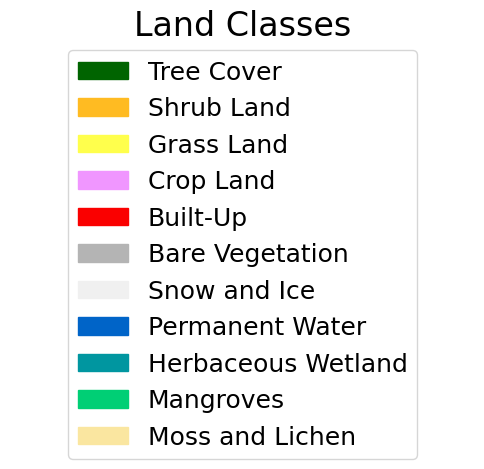

In [9]:
# Land cover classification colormap
class_dict_1 = {
    10: "#006400",  # Tree Cover
    20: "#ffbb22",  # Shrub Land
    30: "#ffff4c",  # Grass Land
    40: "#f096ff",  # Crop Land
    50: "#fa0000",  # Built-Up
    60: "#b4b4b4",  # Bare Vegetation
    70: "#f0f0f0",  # Snow and Ice
    80: "#0064c8",  # Permanent Water
    90: "#0096a0",  # Herbaceous Wetland
    95: "#00cf75",  # Mangroves
    100: "#fae6a0"  # Moss and Lichen
}

# Convert the dictionary to a colormap
colors = [class_dict_1[key] for key in sorted(class_dict_1.keys())]
cmap = plt.matplotlib.colors.ListedColormap(colors)
norm = plt.matplotlib.colors.BoundaryNorm(sorted(class_dict_1.keys()), cmap.N)

labels = ["Tree Cover", "Shrub Land", "Grass Land", "Crop Land",
          "Built-Up", "Bare Vegetation", "Snow and Ice", "Permanent Water", 
          "Herbaceous Wetland", "Mangroves", "Moss and Lichen"]

# Create a list of patches for the legend
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]

# Create the figure for the legend
fig, ax = plt.subplots(figsize=(6, 1))
ax.legend(handles=patches, loc='upper center', fontsize=18)
ax.axis('off')  # Turn off the axis
plt.title("Land Classes", fontsize=24, y=0.92)
plt.tight_layout()
#plt.show()


In [10]:
# Land cover classification colormap for plotting
class_dict = {
    0: (0, 0, 0, 0),  # Transparent color for no-data
    10: "#006400", # Tree Cover
    20: "#ffbb22", # Shrub Land
    30: "#ffff4c", # Grass Land
    40: "#f096ff", # Crop Land
    50: "#fa0000", # Built-Up
    60: "#b4b4b4", # Bare Vegetation
    70: "#f0f0f0", # Snow and Ice
    80: "#0064c8", # Permanent Water
    90: "#0096a0", # Herbaceous Wetland
    95: "#00cf75", # Mangroves
    100: "#fae6a0" # Moss and Lichen
}

# Convert the dictionary to a colormap
colors = [class_dict[key] for key in sorted(class_dict.keys())]
cmap = plt.matplotlib.colors.ListedColormap(colors)
norm = plt.matplotlib.colors.BoundaryNorm(sorted(class_dict.keys()), cmap.N)

Wall time: 2min 25s


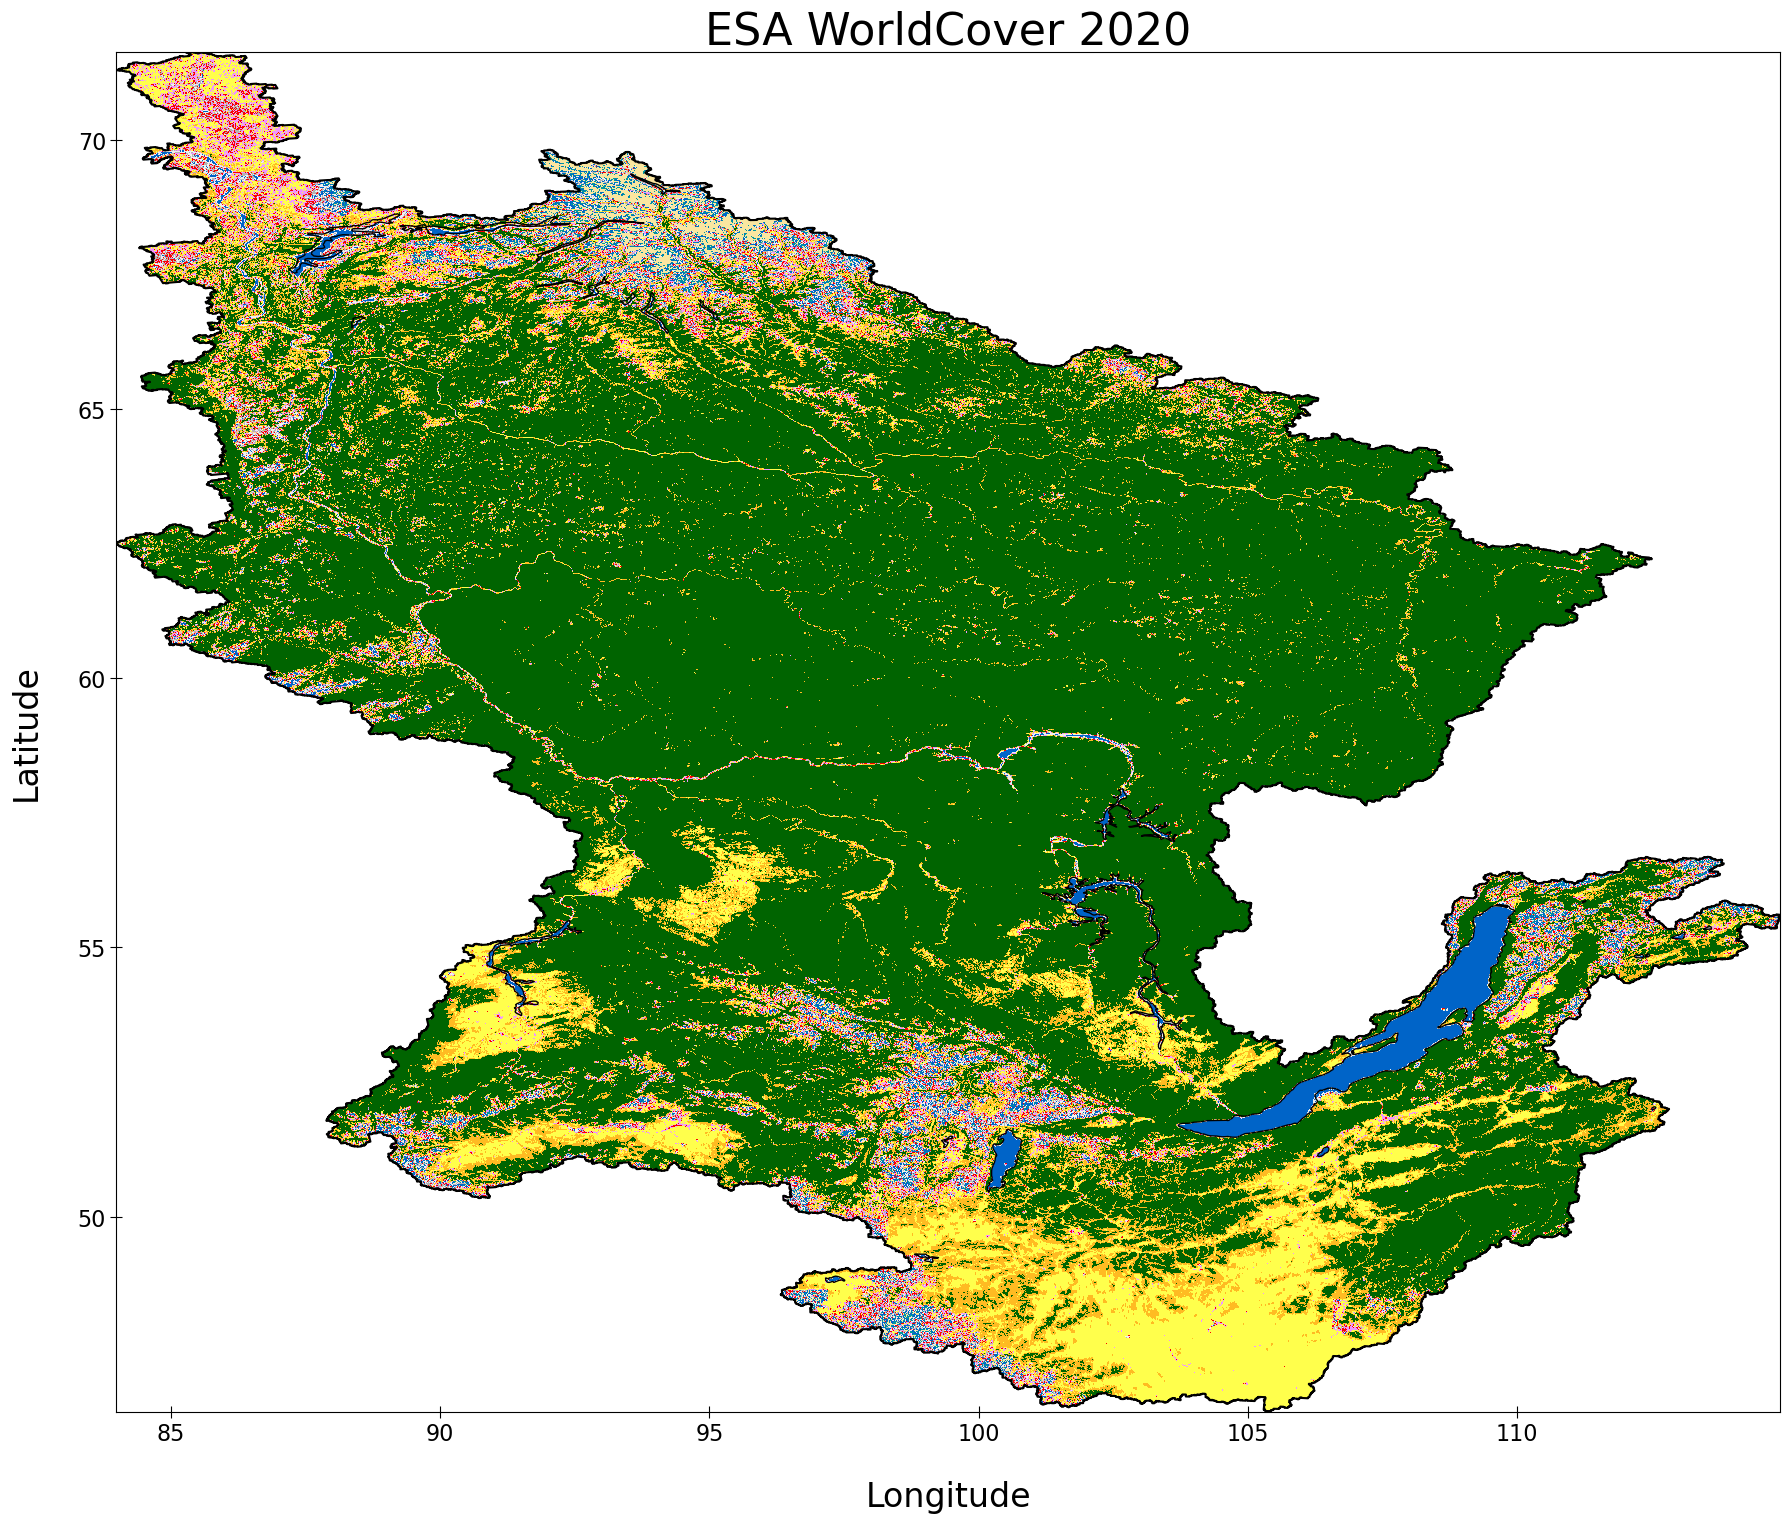

In [11]:
%%time

with rasterio.open(Output_File_Name) as src:
    data = src.read(1, masked=True)
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Plotting the GeoDataFrames as subplots
fig, ax = plt.subplots(figsize=(18, 18))
ax.set_title('ESA WorldCover 2020', fontsize=32)
ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Shapefile
AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=6)
gpd_lakes.plot(ax=ax, color='none', edgecolor='black', lw=1, zorder=6)

# Raster Data
img = ax.imshow(data, cmap=cmap, norm=norm, extent=raster_extent) 

# Setting the plot limits to the extent of the eco data
#xmin, ymin, xmax, ymax = AGRO_Watershed.total_bounds
#ax.set_xlim(xmin, xmax)
#ax.set_ylim(ymin, ymax)

fig.tight_layout()

# Save the plot
#fig.savefig("xxxx.png", dpi=600, bbox_inches='tight')

# Close the plot
#plt.close(fig)

### Reproject Data for Area Calculatons

In [12]:
def reproject_raster(input_raster, output_raster, new_crs):
    """Reproject a raster to a new coordinate reference system."""

    # Check if the output file already exists
    if os.path.exists(output_raster):
        print(f"Output raster {output_raster} already exists!")
        return

    with rasterio.open(input_raster) as src:
        transform, width, height = calculate_default_transform(
            src.crs, new_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': new_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_raster, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=new_crs,
                    resampling=Resampling.bilinear
                )
    print(f"Raster reprojected to {new_crs} and saved as {output_raster}.")

In [13]:
# Reproject Raster
esa_4326 = "ESA_Land_Cover_2020_mosaicked_downsampled_8.tif"
esa_3573 = "ESA_Land_Cover_2020_mosaicked_downsampled_8_3573.tif"
new_crs = 'EPSG:3573'
reproject_raster(esa_4326, esa_3573, new_crs)

Output raster ESA_Land_Cover_2020_mosaicked_downsampled_8_3573.tif already exists!


In [14]:
# Check out the metadata
with rasterio.open(esa_3573) as src:
    meta = src.meta
meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 45024,
 'height': 53553,
 'count': 1,
 'crs': CRS.from_epsg(3573),
 'transform': Affine(57.15358761050101, 0.0, -2715292.3985918206,
        0.0, -57.15358761050101, 4736433.484857388)}

In [15]:
with rasterio.open(esa_3573) as src:
    # Read the raster data
    data = src.read(1, masked=True)
    # Get unique values from the data array
    unique_values = np.unique(data)
    print("Number of Unique Values:", len(unique_values))

    # Calculate statistics on the data array
    median_value = np.nanmedian(data)
    min_value = np.nanmin(data)
    max_value = np.nanmax(data)
    print()
    print(f'Mean: {median_value:.1f}')
    print(f'Range: ({min_value} - {max_value})')
    print()
# Plot
#plt.figure(figsize=(6, 3))
#plt.hist(data.ravel(), bins=100, color='blue', edgecolor='black')
#plt.title('Distribution of Values')
#plt.xlabel('Value')
#plt.ylabel('Frequency')
#plt.grid(True)

Number of Unique Values: 101

Mean: 0.0
Range: (0 - 100)



In [16]:
# Corrected land cover classification colormap
land_cover_dict = {
    10: ("#006400", 'Tree Cover'),
    20: ("#ffbb22", 'Shrub Land'),
    30: ("#ffff4c", 'Grass Land'),
    40: ("#f096ff", 'Crop Land'),
    50: ("#fa0000", 'Built-Up'),
    60: ("#b4b4b4", 'Bare Vegetation'),
    70: ("#f0f0f0", 'Snow and Ice'),
    80: ("#0064c8", 'Permanent Water'),
    90: ("#0096a0", 'Herbaceous Wetland'),
    95: ("#00cf75", 'Mangroves'),
    100: ("#fae6a0", 'Moss and Lichen')
}

# Open the reprojected raster
with rasterio.open(esa_3573) as src:
    data = src.read(1)
    transform = src.transform
    pixel_size_x, pixel_size_y = src.res

# Flatten the data array and remove nodata values
nodata = 0  # Assuming 0 is the nodata value
data_flat = data[data != nodata]

# Calculate unique classes and their counts
unique_classes, counts = np.unique(data_flat, return_counts=True)

# Filter only relevant classes and values
relevant_classes = [cls for cls in unique_classes if cls in land_cover_dict]
colors = [land_cover_dict[cls][0] for cls in relevant_classes]
labels = [land_cover_dict[cls][1] for cls in relevant_classes]
relevant_counts = [counts[np.where(unique_classes == cls)[0][0]] for cls in relevant_classes]

# Convert counts to km^2 using raster resolution (area of 1 pixel)
pixel_area_km2 = abs(transform[0] * transform[4]) / (10**6)  # Assuming that transform gives pixel size in meters
area_km2_values = [count * pixel_area_km2 for count in relevant_counts]

# Create a DataFrame
df_esa = pd.DataFrame({
    'Land_Cover_Class': [land_cover_dict[cls][1] for cls in relevant_classes],
    'Color': [land_cover_dict[cls][0] for cls in relevant_classes],
    'Area_km2': area_km2_values
})

# Set the class codes (like 10, 20, 30, etc.) as the index
df_esa.index = relevant_classes

# Calculate the total area
total_area = df_esa['Area_km2'].sum()

# Calculate the percent area for each class and add it as a new column to the DataFrame
df_esa['Percent_Area'] = (df_esa['Area_km2'] / total_area) * 100

df_esa = df_esa.sort_values(by='Percent_Area', ascending=False)

df_esa['Land_Cover_Class'] = ['Tree\nCover', 'Grass\nLand', 'Permanent\nWater',  
              'Moss and\nLichen',  'Crop\nLand',  'Shrub\nLand',  
              'Herbaceous\nWetland',  'Bare\nVegetation',  
              'Built-Up',  'Snow\nand Ice',  'Mangroves']

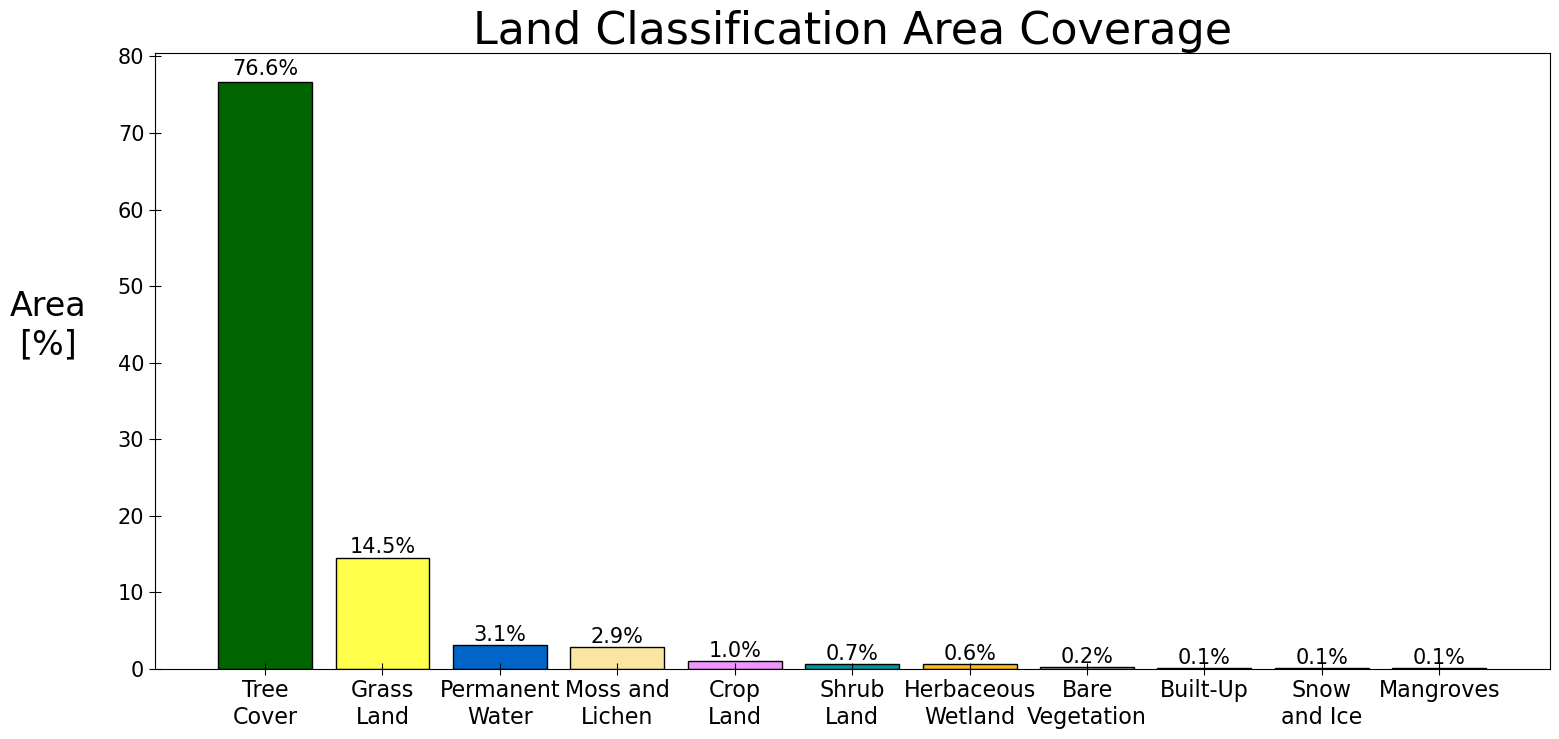

In [17]:
# Create the bar plot using the top 15 records
fig, ax = plt.subplots(figsize=(18, 8))
bars = ax.bar(df_esa['Land_Cover_Class'], df_esa['Percent_Area'], color=df_esa['Color'], edgecolor='black', align='center')

# Set title and labels
ax.set_title('Land Classification Area Coverage', fontsize=32)
ax.set_ylabel('Area\n[%]', fontsize=24, labelpad=50, rotation=0)
#ax.set_xlabel('Watershed Code', labelpad=50, fontsize=24)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=18)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=18)

# Rotate x labels for better readability
plt.xticks(rotation=0, ha='center', fontsize=16)
plt.yticks(fontsize=15)

# Add text above each bar
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    # Multiply by 100 to convert proportion to percentage
    percentage = df_esa['Percent_Area'].iloc[idx]
    # Format with one decimal place and add a percentage sign
    ax.text(bar.get_x() + bar.get_width()/2, 
            yval + 0.005*yval, 
            '{:.1f}%'.format(percentage), 
            ha='center', va='bottom', fontsize=15)


#fig.savefig("xxx.png", dpi=600, bbox_inches='tight')